Download dataset gồm 23 cột (22 features nhưng dùng 8 features)

In [ ]:
!gdown --id '1kDCXBXKchTBDrcMYWYp4hscTDrJ3ZBXD'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kDCXBXKchTBDrcMYWYp4hscTDrJ3ZBXD
To: /content/FlowStatsfile.csv
100% 90.3M/90.3M [00:01<00:00, 90.2MB/s]


1. Vì địa chỉ IP và port có độ đa dạng cao (bất cứ địa chỉ ip và port nào đều có thể là normal hoặc ddos) nên nhóm sử dụng các đặc trưng hành vi của luồng dữ liệu để làm thuộc tính phân loại Machine Learning (flow_duration_sec, packet_count, byte_count, packet_count_per_second, byte_count_per_second, ip_proto, icmp_code, icmp_type)
2. Để cân bằng dữ liệu đầu vào: oversampling dùng thư viện imblearn
3. Lưu lại file csv để dùng training

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Load dataset
flow_dataset = pd.read_csv('/content/FlowStatsfile.csv')

# Select specific columns for features
selected_features = [
    'flow_duration_sec', 'packet_count', 'byte_count',
    'packet_count_per_second', 'byte_count_per_second',
    'ip_proto', 'icmp_code', 'icmp_type'
]

X_flow = flow_dataset[selected_features].values
X_flow = X_flow.astype('float64')

# Target column (assuming the last column is the target)
y_flow = flow_dataset.iloc[:, -1].values

# Balance the dataset using SMOTE
smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X_flow, y_flow)

# Combine features and target into a single DataFrame
preprocessed_data = pd.DataFrame(X_balanced, columns=selected_features)
preprocessed_data['target'] = y_balanced

# Save the preprocessed data to a CSV file
preprocessed_data.to_csv('preprocessed_flow_data.csv', index=False)
print("Preprocessed data saved to preprocessed_flow_data.csv")

Preprocessed data saved to preprocessed_flow_data.csv


Update thư viện skitlearn để xuất model cùng với version hệ thống

In [ ]:
!pip install scikit-learn==1.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Class Machine Learning gồm phương thức khởi tạo đọc dữ liệu đầu vào, các phương thức model ML, lưu model và inference model

In [ ]:
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import pickle

class MachineLearning():

    def __init__(self):
        print("Loading dataset ...")

        self.counter = 0

        # Load preprocessed dataset
        self.flow_dataset = pd.read_csv('preprocessed_flow_data.csv')

        # Separate features and target
        self.X_flow = self.flow_dataset.drop(columns=['target']).values
        self.y_flow = self.flow_dataset['target'].values

        # Split the dataset into training and testing sets
        self.X_flow_train, self.X_flow_test, self.y_flow_train, self.y_flow_test = train_test_split(self.X_flow, self.y_flow, test_size=0.25, stratify=self.y_flow, random_state=42)

    def LR(self):
        print("------------------------------------------------------------------------------")
        print("Logistic Regression ...")

        self.classifier = LogisticRegression(solver='liblinear', random_state=42, max_iter=100000, C=0.1, class_weight='balanced')
        self.Confusion_matrix('Logistic_Regression')

    def KNN(self):
        print("------------------------------------------------------------------------------")
        print("K-NEAREST NEIGHBORS ...")

        self.classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
        self.Confusion_matrix('KNN')

    def DT(self):
        print("------------------------------------------------------------------------------")
        print("DECISION TREE ...")

        self.classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
        self.Confusion_matrix('Decision_Tree')

    def RF(self):
        print("------------------------------------------------------------------------------")
        print("RANDOM FOREST ...")

        self.classifier = RandomForestClassifier(n_estimators=10, criterion="entropy", random_state=42)
        self.Confusion_matrix('Random_Forest')

    def Confusion_matrix(self, model_name):
        self.counter += 1

        self.flow_model = self.classifier.fit(self.X_flow_train, self.y_flow_train)
        self.y_flow_pred = self.flow_model.predict(self.X_flow_test)

        print("------------------------------------------------------------------------------")
        print("Confusion Matrix")
        cm = confusion_matrix(self.y_flow_test, self.y_flow_pred)

        acc = accuracy_score(self.y_flow_test, self.y_flow_pred)
        recall = recall_score(self.y_flow_test, self.y_flow_pred, average='weighted') # Use 'macro' or 'micro' for multi-class
        precision = precision_score(self.y_flow_test, self.y_flow_pred, average='weighted') # Use 'macro' or 'micro' for multi-class
        f1 = f1_score(self.y_flow_test, self.y_flow_pred, average='weighted') # Use 'macro' or 'micro' for multi-class
        auc_roc = roc_auc_score(self.y_flow_test, self.y_flow_pred)
        balanced_acc = balanced_accuracy_score(self.y_flow_test, self.y_flow_pred)
        print("F1 Score = {0:.2f} %".format(f1 * 100))
        print(f'Balanced accuracy: {balanced_acc}')
        print("------------------------------------------------------------------------------")

        # Plot confusion matrix using seaborn heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()

        # Save the model
        self.save_model(model_name)

    def save_model(self, model_name):
        filename = f'{model_name}.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(self.flow_model, file)
        print(f"Model saved as {filename}")

    def inference(self, model_name, X_new):
        filename = f'{model_name}.pkl'
        with open(filename, 'rb') as file:
            loaded_model = pickle.load(file)
        y_pred_new = loaded_model.predict(X_new)
        return y_pred_new


Tạo đối tượng ml và training các model, tính thời gian train-test

Loading dataset ...
------------------------------------------------------------------------------
Logistic Regression ...
------------------------------------------------------------------------------
Confusion Matrix
F1 Score = 63.78 %
Balanced accuracy: 0.6656407945530339
------------------------------------------------------------------------------


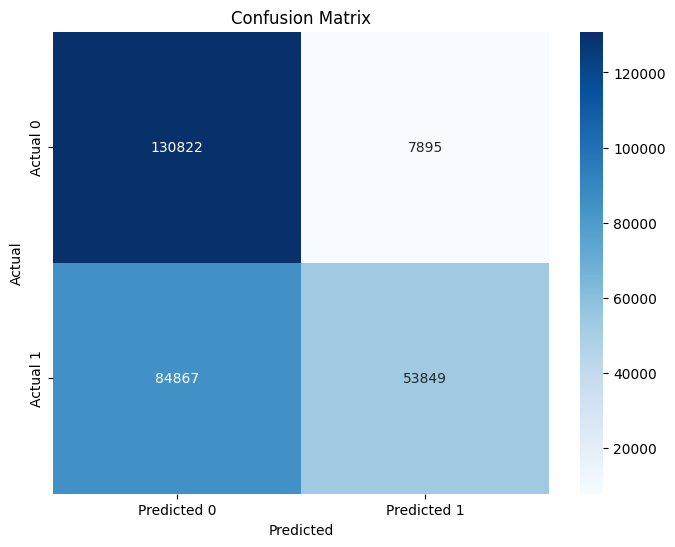

Model saved as Logistic_Regression.pkl
LEARNING and PREDICTING Time:  0:00:03.261843
------------------------------------------------------------------------------
DECISION TREE ...
------------------------------------------------------------------------------
Confusion Matrix
F1 Score = 93.26 %
Balanced accuracy: 0.9328596671315393
------------------------------------------------------------------------------


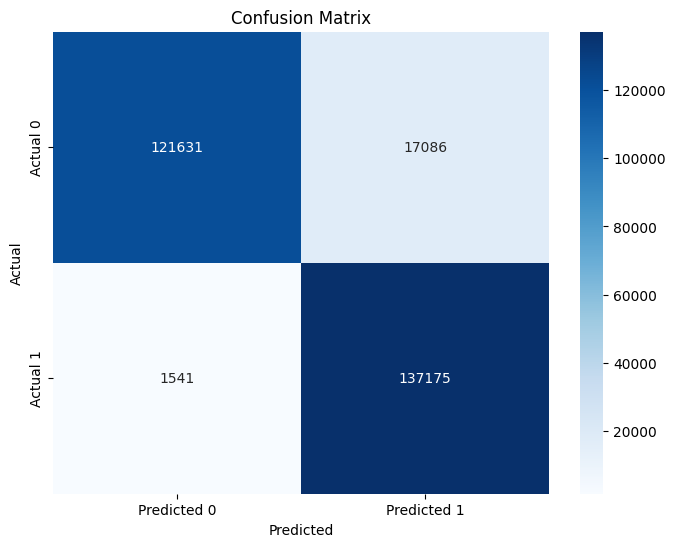

Model saved as Decision_Tree.pkl
LEARNING and PREDICTING Time:  0:00:03.512948
------------------------------------------------------------------------------
RANDOM FOREST ...
------------------------------------------------------------------------------
Confusion Matrix
F1 Score = 93.26 %
Balanced accuracy: 0.9328164133411252
------------------------------------------------------------------------------


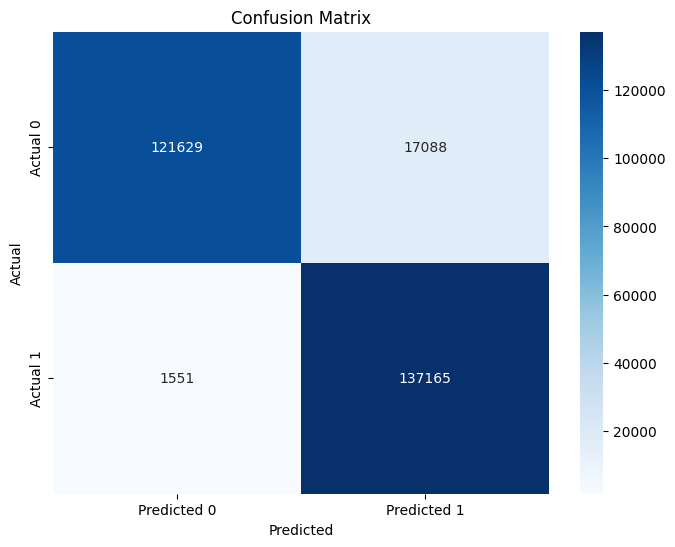

Model saved as Random_Forest.pkl
LEARNING and PREDICTING Time:  0:00:12.046673
------------------------------------------------------------------------------
K-NEAREST NEIGHBORS ...
------------------------------------------------------------------------------
Confusion Matrix
F1 Score = 92.88 %
Balanced accuracy: 0.9288550078047424
------------------------------------------------------------------------------


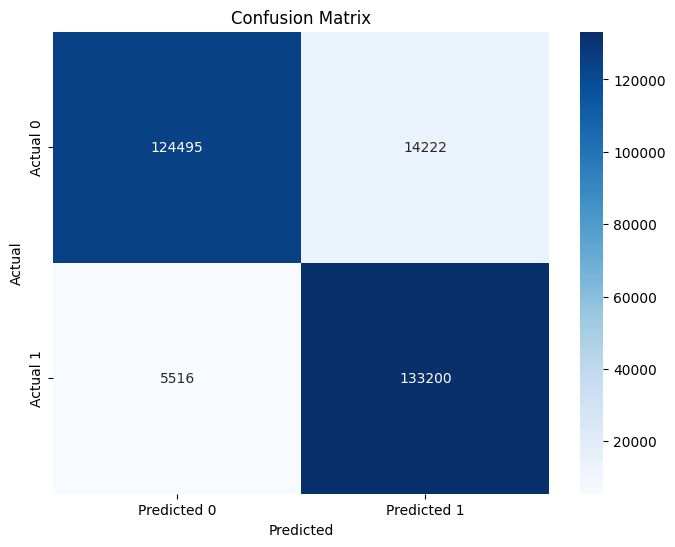

Model saved as KNN.pkl
LEARNING and PREDICTING Time:  0:03:28.971352
Script Time:  0:03:49.283902


In [ ]:
start_script = datetime.now()
ml = MachineLearning()
start = datetime.now()
ml.LR()
end = datetime.now()
print("LEARNING and PREDICTING Time: ", (end-start))

start = datetime.now()
ml.DT()
end = datetime.now()
print("LEARNING and PREDICTING Time: ", (end-start))

start = datetime.now()
ml.RF()
end = datetime.now()
print("LEARNING and PREDICTING Time: ", (end-start))

start = datetime.now()
ml.KNN()
end = datetime.now()
print("LEARNING and PREDICTING Time: ", (end-start))

end_script = datetime.now()
print("Script Time: ", (end_script-start_script))

Ví dụ về cách Inference model vừa train

In [ ]:
# Perform inference using the Logistic Regression model
y_pred_new = ml.inference('Logistic_Regression', ml.X_flow_test[0].reshape(1, -1))
print(f'Predicted Logistic_Regression: {y_pred_new}')

y_pred_new = ml.inference('Decision_Tree', ml.X_flow_test[0].reshape(1, -1))
print(f'Predicted Decision_Tree: {y_pred_new}')

y_pred_new = ml.inference('Random_Forest', ml.X_flow_test[0].reshape(1, -1))
print(f'Predicted Random_Forest: {y_pred_new}')

y_pred_new = ml.inference('KNN', ml.X_flow_test[0].reshape(1, -1))
print(f'Predicted KNN: {y_pred_new}')

print(f'Actual label: {ml.y_flow_test[0]}')

Predicted Logistic_Regression: [0]
Predicted Decision_Tree: [0]
Predicted Random_Forest: [0]
Predicted KNN: [0]
Actual label: 0


Kết nối Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Lưu model đã train vào Drive, tải về để sử dụng trong hệ thống

In [ ]:
!cp '/content/KNN.pkl' '/content/drive/MyDrive/SDN/Hai Options'
!cp '/content/Decision_Tree.pkl' '/content/drive/MyDrive/SDN/Hai Options'
!cp '/content/Logistic_Regression.pkl' '/content/drive/MyDrive/SDN/Hai Options'
!cp '/content/Random_Forest.pkl' '/content/drive/MyDrive/SDN/Hai Options'
!cp '/content/preprocessed_flow_data.csv' '/content/drive/MyDrive/SDN/Hai Options'